# Projeto Final de Machine Learning
Feito por: _Henrique Bucci_ e _Marcelo Alonso_

Dados e informações: https://www.kaggle.com/datasets/marcopale/housing/data

**Perguntas**  
- Posso remover o PID?
    - **R:** Sim
- Posso criar colunas a partir de contas de outras antes de fazer a seleção?
    - **R:** Sim
- Se eu aplicar PolynomialFeatures nos dados, eles também contam como features para a contagem?
    - **R:** Fazer PolyFeatures depois de selecionar as features
- Posso utilizar correlação na análise exploratória?
    - **R:** Pode, mas é "inútil"
- Posso utilizar métodos de clustering na pipeline para incluir a classificação como uma nova feature?
    - **R:** SoftMax no resultado do Kmeans para exagerar a classe mais próxima.
- Posso utilizar algum método de Dimensionality Reduction (ex: PCA) para me ajudar a escolher as features?
    - **R:** Sim.


Testar stacking: Treinar diversos modelos e treinar um modelo final com os predicts destes modelos.

#### ANOTAÇÕES
Utilizar LASSO para seleção de features.

Regressão linear para ignorar outliers.

RANSAC -> regressao linear que ignora outliers

## Etapa 0

Nesta etapa, iremos:
- Importar bibliotecas
- Carregar os dados
- Verificar se existem colunas que não fazem sentido serem colocadas no dataset final (como ID ou algum outro tipo de identificador arbitrário), olhando apenas a descrição das colunas.
- Separar o dataset em Treino-Teste

### Bibliotecas

In [1]:
import pandas as pd
from datetime import datetime
from utils import *


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

### Constantes

In [2]:
SEED = 420

### Carregamento e Pré-processamento dos Dados

In [3]:
dataset = load_data()
dataset.head()

,Order,PID,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,...,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS.SubClass      2930 non-null   int64  
 3   MS.Zoning        2930 non-null   object 
 4   Lot.Frontage     2440 non-null   float64
 5   Lot.Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot.Shape        2930 non-null   object 
 9   Land.Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot.Config       2930 non-null   object 
 12  Land.Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition.1      2930 non-null   object 
 15  Condition.2      2930 non-null   object 
 16  Bldg.Type        2930 non-null   object 
 17  House.Style   

In [5]:
"""
Neste caso, a presença de duplicatas não seria intencional, uma vez que cada casa deveria ser única.
Portanto, vamos removê-las.
"""
dataset.drop_duplicates(inplace=True) # Removendo duplicatas

In [6]:
"""
Como a primeira coluna é o ID da observação e a segunda é um identificador, podemos removê-las, uma vez que estes são valores arbitrários.
"""
dataset = dataset.iloc[:, 2:] # Estamos removendo as duas primeiras colunas, que são o ID e o PID (Parcel identification number)

### Criando novas features

Ao analisarmos as features da forma descrita acima, vimos espaço para a criação de novas features que podem ser úteis na modelagem dos dados:
- **Tot Lot Area** : `Lot Frontage + Lot Area`
- **Bsmt Tot Bath** : `Bsmt Full Bath + 0.5*Bsmt Half Bath`
- **Garage Area/Car** : `Garage Area / Garage Cars`
- **Tot Porch SF** : `Open Porch SF + Enclosed Porch + 3Ssn Porch + Screen Porch`
- **Date Sold** : `str(Month Sold + : + Year Sold)`

In [7]:
dataset.loc[:, 'Tot.Lot.Area'] = dataset.loc[:, 'Lot.Frontage'] + dataset.loc[:, 'Lot.Area']
dataset.loc[:, 'Bsmt.Tot.Bath'] = dataset.loc[:, 'Bsmt.Full.Bath'] + 0.5*dataset.loc[:, 'Bsmt.Half.Bath']
dataset.loc[:, 'Garage.Area/Cars'] = dataset.loc[:, 'Garage.Area'] / dataset.loc[:, 'Garage.Cars']
dataset.loc[:, 'Tot.Porch.SF'] = dataset.loc[:, 'Open.Porch.SF'] + dataset.loc[:, 'X3Ssn.Porch'] + dataset.loc[:, 'Enclosed.Porch'] + dataset.loc[:, 'Screen.Porch']
dataset.loc[:, 'Date.Sold'] = pd.to_datetime(dict(year=dataset['Yr.Sold'], month=dataset['Mo.Sold'], day=1)).apply(lambda x: x.timestamp())

### Train-Test Split

- A partir de agora, usaremos apenas o dataset de treino, a partição de teste será tratada como se não existisse ainda.
- O dataset total será dividido em uma proporção 80/20, uma vez que temos poucos dados (2930 no total).
- Por não se tratar de uma série temporal, podemos aplicar uma aleatoriedade na partição.

In [8]:
X, y = dataset.drop('SalePrice', axis=1), dataset.loc[:, 'SalePrice']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Etapa 1

### Análise Exploratória

Nesta parte, iremos fazer uma análise global dos dados, apenas para garantir a integridade destes.  
Assim sendo, iremos procurar entender quais são as features e target, quais são seus respectivos tipos e buscar outras informações como:
- Dados nulos
- Dados duplicados
- Outliers
- Spikes
- Erros grosseiros

Além disso, iremos buscar saber a distribuição e a "cara" de cada variável.

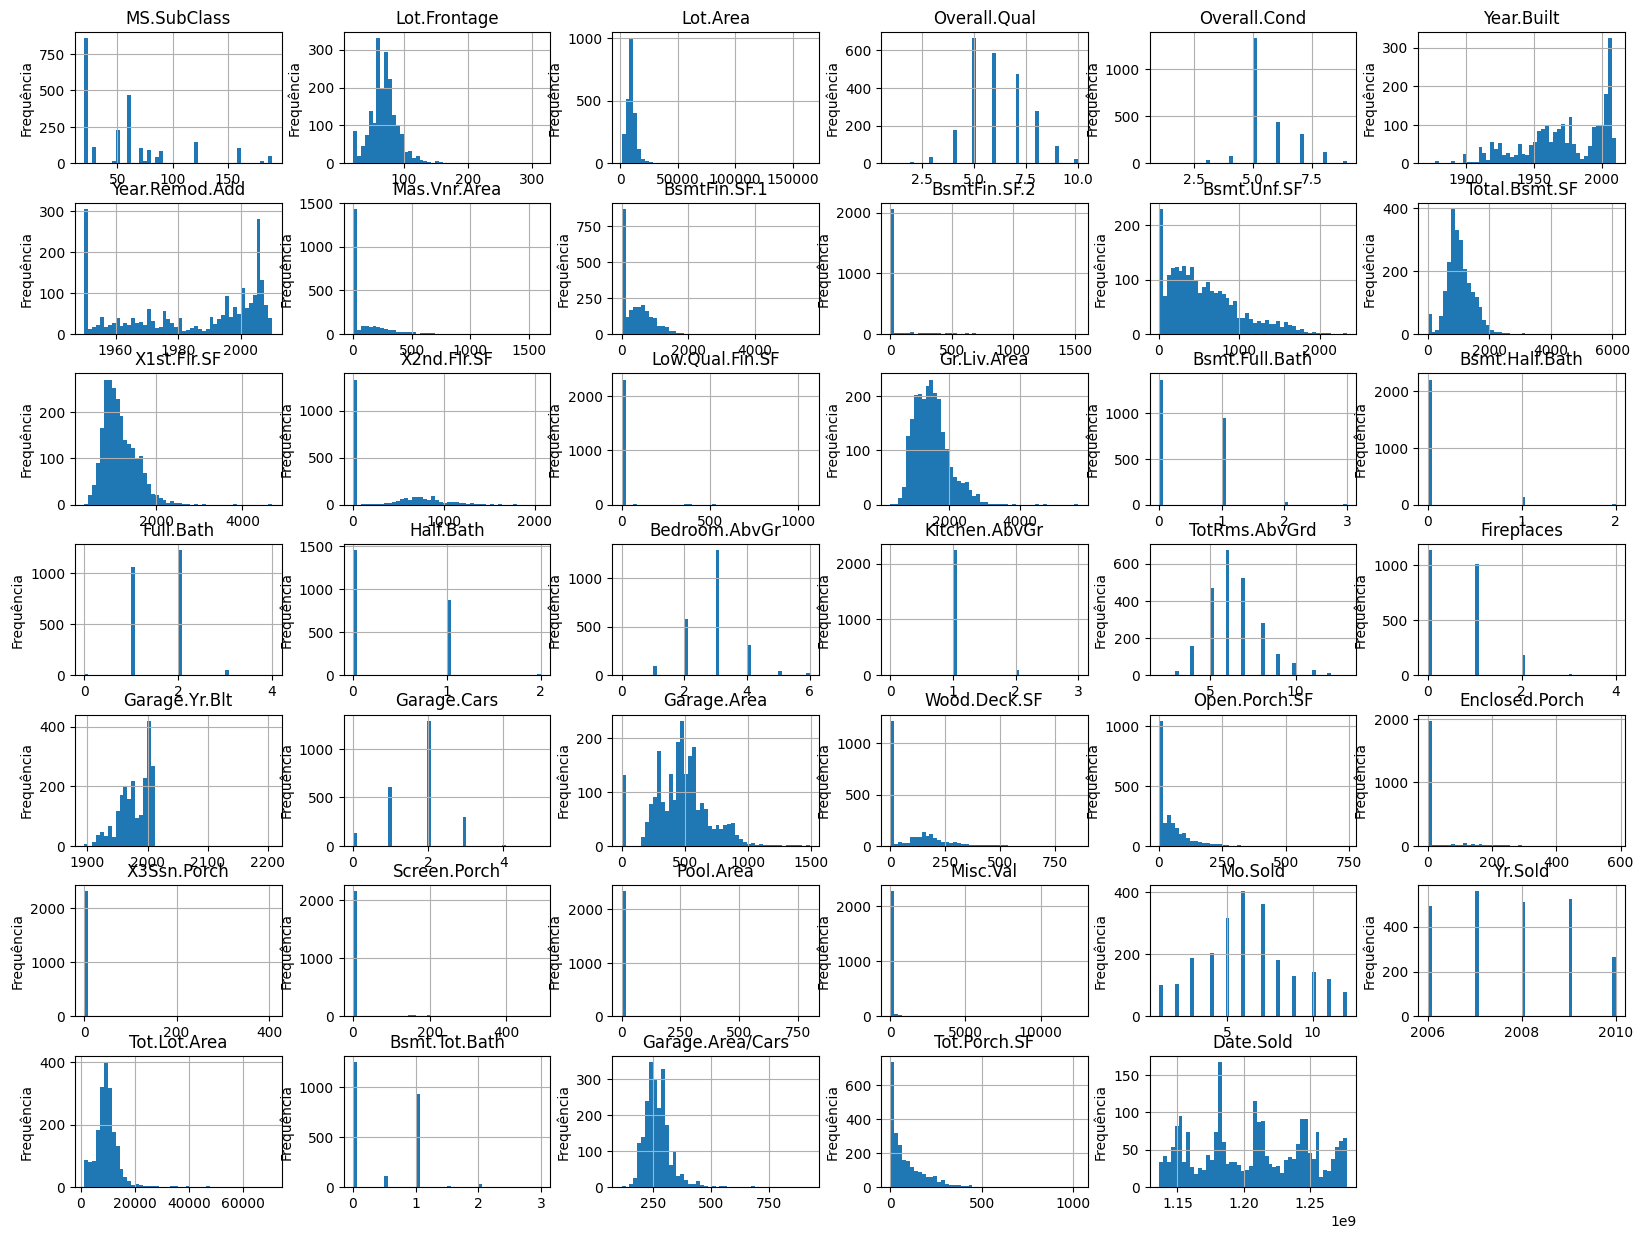

In [10]:
def plot_Xtrain(X_train):
    n_bins = np.floor(np.sqrt(X_train.shape[0])).astype(int).item()
    
    result = X_train \
        .select_dtypes(include='number') \
        .hist(bins=n_bins, figsize=(20, 15))

    for subplot in result.flatten():
        column = subplot.get_title()
        if not column:
            continue
        subplot.set_ylabel('Frequência')

    plt.show()

plot_Xtrain(X_train)

In [11]:
# Agora, basta remover os outliers encontrados no target do dataset
X_train, y_train = remove_outliers(X_train, y_train)

In [12]:
cauda_direita = ['Lot.Frontage', 'Lot.Area', 'Mas.Vnr.Area', 'BsmtFin.SF.1', 
                 'Bsmt.Unf.SF', 'Total.Bsmt.SF', 'X1st.Flr.SF', 'Gr.Liv.Area', 
                 'Garage.Area', 'Wood.Deck.SF', 'Open.Porch.SF', 'Enclosed.Porch', 
                 'Screen.Porch', 'X3Ssn.Porch', 'Tot.Lot.Area', 'Garage.Area/Cars', 'Tot.Porch.SF']

categorical = X.select_dtypes(include='object').columns.tolist()
numerical = X.select_dtypes(include='number').columns.tolist()

len([x for x in X_train[numerical].columns if x in X_train[cauda_direita].columns])

17

In [ ]:
col_transformer = ColumnTransformer(
    transformers=[
        ('log', FunctionTransformer(np.log1p, validate=False), cauda_direita),
        # ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
    ],
    remainder='passthrough'
)

['Lot.Frontage',
 'Lot.Area',
 'Mas.Vnr.Area',
 'BsmtFin.SF.1',
 'Bsmt.Unf.SF',
 'Total.Bsmt.SF',
 'X1st.Flr.SF',
 'Gr.Liv.Area',
 'Garage.Area',
 'Wood.Deck.SF',
 'Open.Porch.SF',
 'Enclosed.Porch',
 'Screen.Porch',
 'X3Ssn.Porch',
 'Tot.Lot.Area',
 'Garage.Area/Cars',
 'Tot.Porch.SF']

In [ ]:
X_train_tr = col_transformer.fit_transform(X_train[numerical])


AttributeError: Transformer log (type FunctionTransformer) does not provide get_feature_names_out.

In [ ]:
X_train_tr = pd.DataFrame(X_train_tr, columns=numerical)
X_train_tr

,MS.SubClass,Lot.Frontage,Lot.Area,Overall.Qual,Overall.Cond,Year.Built,Year.Remod.Add,Mas.Vnr.Area,BsmtFin.SF.1,BsmtFin.SF.2,...,Screen.Porch,Pool.Area,Misc.Val,Mo.Sold,Yr.Sold,Tot.Lot.Area,Bsmt.Tot.Bath,Garage.Area/Cars,Tot.Porch.SF,Date.Sold
0,NaN,9.127611,5.720312,6.558198,5.424950,6.836259,7.218910,7.895063,6.161207,5.472271,...,9.0,2.0,1990.0,2.0,0.0,0.0,6.0,2008.0,1.0,1.212278e+09
1,4.812184,9.386308,0.000000,0.000000,7.496097,7.496097,7.496097,7.496097,6.555357,5.666427,...,7.0,0.0,2007.0,2.0,0.0,0.0,5.0,2009.0,0.0,1.241136e+09
2,3.931826,8.699681,0.000000,4.653960,6.248043,6.672033,6.672033,6.672033,5.525453,0.000000,...,5.0,0.0,1948.0,1.0,0.0,0.0,4.0,2008.0,0.0,1.207008e+09
3,4.158883,8.939712,0.000000,0.000000,6.687109,6.687109,6.999422,7.412764,6.089045,5.236442,...,8.0,0.0,1958.0,2.0,0.0,0.0,5.0,2008.0,0.0,1.209600e+09
4,4.369448,9.770185,0.000000,0.000000,6.816736,6.816736,6.816736,7.285507,5.802118,5.262690,...,6.0,1.0,1948.0,1.0,0.0,0.0,1.0,2010.0,0.5,1.262304e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2232,3.970292,8.738896,0.000000,0.000000,6.705639,6.705639,6.705639,7.070724,6.270988,4.727388,...,6.0,1.0,1985.0,2.0,0.0,400.0,9.0,2006.0,0.0,1.157069e+09
2233,4.317488,9.285355,0.000000,6.133398,5.733341,6.961296,6.967909,6.967909,6.137727,4.744932,...,4.0,0.0,1990.0,2.0,0.0,0.0,7.0,2009.0,1.0,1.246406e+09
2234,4.127134,8.238273,0.000000,6.867974,5.587249,7.112327,7.112327,7.112327,6.184149,4.897840,...,4.0,2.0,1981.0,2.0,0.0,0.0,9.0,2009.0,1.0,1.251763e+09
2235,4.369448,9.224342,5.164786,0.000000,6.970730,6.970730,7.208600,7.208600,6.171701,0.000000,...,7.0,1.0,1974.0,2.0,0.0,0.0,8.0,2009.0,0.0,1.249085e+09


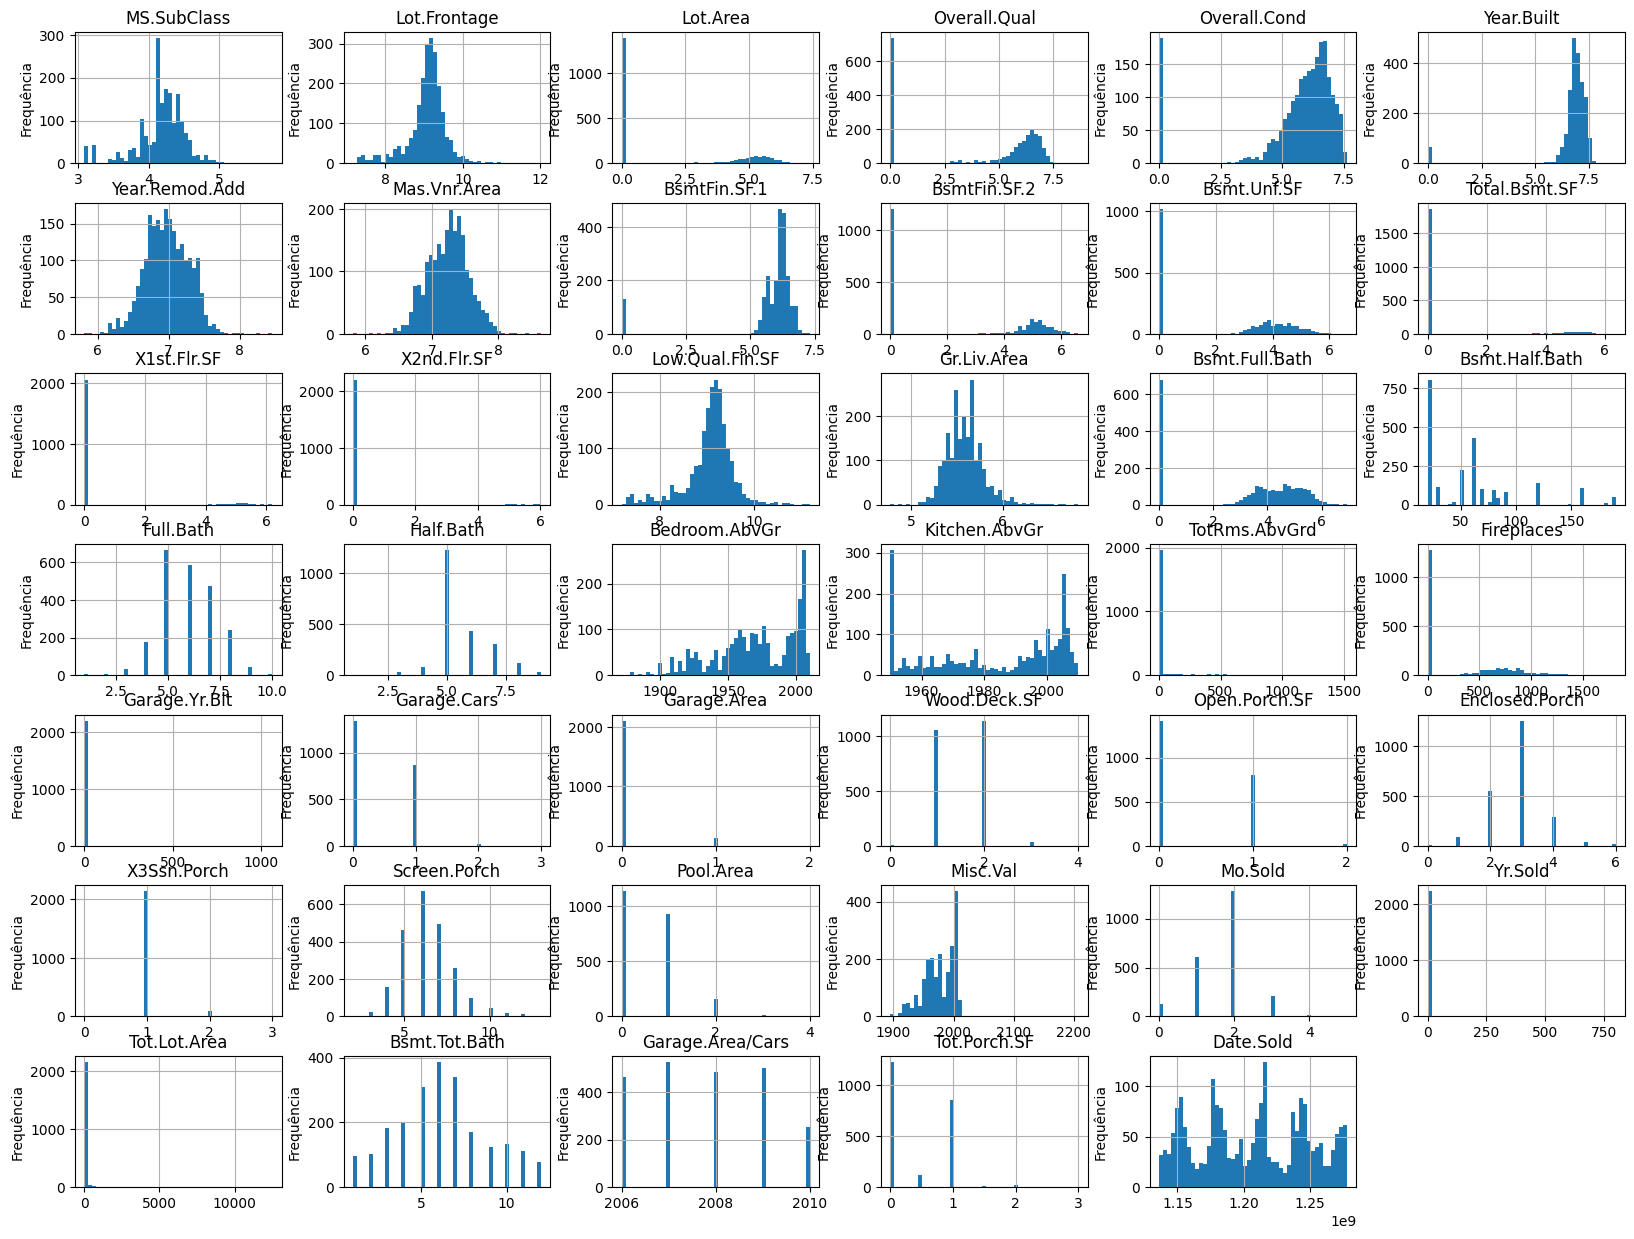

In [15]:
plot_Xtrain(X_train_tr)

## Parte 5

Seleção de modelos com GridSearchCV

In [16]:
param_grid = [{
    'regressor' : [LinearRegression(), DummyRegressor()],
}, {
    'regressor': [Lasso(), Ridge()],
    'alpha': [0.1, 1, 10, 100],
}, {
    'regressor': [ElasticNet()],
    'alpha': [0.1, 1, 10, 100],
    'l1_ratio': [0.1, 0.5, 0.9]
}, {
    'regressor': [RandomForestRegressor()],
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}, {
    'regressor': [GradientBoostingRegressor()],
    'n_estimators': [10, 50, 100],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}]